# ResistivityLogging1D
### An interactive notebook application for learning the resistivity logging for different models

* Plot potential curve in 1D
* Plot layered-space model and apparent resistivity in 1D
* Explore how potential and apparent resistivity change for different parameters in 1D
* "Run All" to get the default result
* Plot lines the way you like by changing the plotting codes

**Bugs and improvement: chentaosx@hotmail.com**

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

## Function definitions

In [2]:
# plane info
class plane():
    def __init__(self, num, loc):
        self.num = num   # number of plane
        self.loc = loc   # location of plane

In [3]:
# layer info
class layer():
    def __init__(self, num, rho):
        self.num = num   # number of layer
        self.rho = rho   # resistivity of layer

In [4]:
# Potential Electrode
class  potentialElectrode():
    def __init__(self, radius, depth):
        self.radius = radius   # radius of the PE
        self.depth = depth   # depth of the PE

In [5]:
# Current Electrode
class currentElectrode():
    def __init__(self, intensity, loc, toolSize = 0):
        self.intensity = intensity   # intensity of the CE
        self.toolSize = toolSize
        self.loc = loc - self.toolSize - 0.00001   # location of the CE
        
    def update_layerInd(self, layerInd):
        self.layerInd = layerInd
    
    def update_rho(self, rho):
        self.rho = rho  

In [6]:
# Hankel transform
# refer paper "1997, Guptasarma and Singh, New digital linear filters for Hankel J0 and J1 transforms" for more details
def HankelTransform(r):
    a = -8.38850000000e+00   # shift
    s = 9.04226468670e-02   # sampling space
    n = 120   # num of filter weights
    
    # filterWeights for J0(120 order)
    weights = [ 9.62801364263e-07, -5.02069203805e-06,  1.25268783953e-05, -1.99324417376e-05,
               2.29149033546e-05, -2.04737583809e-05,  1.49952002937e-05, -9.37502840980e-06,
               5.20156955323e-06, -2.62939890538e-06,  1.26550848081e-06, -5.73156151923e-07,
               2.76281274155e-07, -1.09963734387e-07,  7.38038330280e-08, -9.31614600001e-09,
               3.87247135578e-08,  2.10303178461e-08,  4.10556513877e-08,  4.13077946246e-08,
               5.68828741789e-08,  6.59543638130e-08,  8.40811858728e-08,  1.01532550003e-07,
               1.26437360082e-07,  1.54733678097e-07,  1.91218582499e-07,  2.35008851918e-07,
               2.89750329490e-07,  3.56550504341e-07,  4.39299297826e-07,  5.40794544880e-07,
               6.66136379541e-07,  8.20175040653e-07,  1.01015545059e-06,  1.24384500153e-06,
               1.53187399787e-06,  1.88633707689e-06,  2.32307100992e-06,  2.86067883258e-06,
               3.52293208580e-06,  4.33827546442e-06,  5.34253613351e-06,  6.57906223200e-06,
               8.10198829111e-06,  9.97723263578e-06,  1.22867312381e-05,  1.51305855976e-05,
               1.86329431672e-05,  2.29456891669e-05,  2.82570465155e-05,  3.47973610445e-05,
               4.28521099371e-05,  5.27705217882e-05,  6.49856943660e-05,  8.00269662180e-05,
               9.85515408752e-05,  1.21361571831e-04,  1.49454562334e-04,  1.84045784500e-04,
               2.26649641428e-04,  2.79106748890e-04,  3.43716968725e-04,  4.23267056591e-04,
               5.21251001943e-04,  6.41886194381e-04,  7.90483105615e-04,  9.73420647376e-04,
               1.19877439042e-03,  1.47618560844e-03,  1.81794224454e-03,  2.23860214971e-03,
               2.75687537633e-03,  3.39471308297e-03,  4.18062141752e-03,  5.14762977308e-03,
               6.33918155348e-03,  7.80480111772e-03,  9.61064602702e-03,  1.18304971234e-02,
               1.45647517743e-02,  1.79219149417e-02,  2.20527911163e-02,  2.71124775541e-02,
               3.33214363101e-02,  4.08864842127e-02,  5.01074356716e-02,  6.12084049407e-02,
               7.45146949048e-02,  9.00780900611e-02,  1.07940155413e-01,  1.27267746478e-01,
               1.46676027814e-01,  1.62254276550e-01,  1.68045766353e-01,  1.52383204788e-01,
               1.01214136498e-01, -2.44389126667e-03, -1.54078468398e-01, -3.03214415655e-01,
               -2.97674373379e-01, 7.93541259524e-03,  4.26273267393e-01,  1.00032384844e-01,
               -4.94117404043e-01, 3.92604878741e-01, -1.90111691178e-01,  7.43654896362e-02,
               -2.78508428343e-02, 1.09992061155e-02, -4.69798719697e-03,  2.12587632706e-03,
               -9.81986734159e-04, 4.44992546836e-04, -1.89983519162e-04,  7.31024164292e-05,
               -2.40057837293e-05, 6.23096824846e-06, -1.12363896552e-06,  1.04470606055e-07]
    
    x = np.arange(1, n + 1)
    x = 1/r * 10 ** (a + (x - 1) * s)
    return x, weights

In [7]:
# kernel of the Hankel integral
# refer paper "2000, Sato, Potential field from a dc current source arbitrarily located in a nonuniform layered medium" for more details
def kernel_DC1D(x, pe, ce, layersNum, layersRho, layersThickness, planesNum, planesLoc):
    
    PEIndex = np.min(np.where(planesLoc >= pe.depth))
    e = 2.7182818284590451
    
    # g and r
    for i in range(1, PEIndex + 1):
        if 1 == i:
            f = 1
            s = 1
            g = (1 - s * f)/(1 + s * f)
            layerIndex = 1
        elif (1 != i) & (pe.depth > planesLoc[layerIndex]):
            layerIndex = layerIndex + 1
            if layerIndex <= ce.layerInd:
                s = layersRho[layerIndex - 2]/layersRho[layerIndex - 1]
                f = (1 - g * e**(-2 * x * layersThickness[layerIndex - 2]))/ \
                    (1 + g * e**(-2 * x * layersThickness[layerIndex - 2]))
                g = (1 - s * f)/(1 + s * f)
            elif layerIndex == ce.layerInd + 1:
                f = (1 - g * e**(-2 * x * layersThickness[layerIndex - 2]))/ \
                    (1 + g * e**(-2 * x * layersThickness[layerIndex - 2]))
                r = f/(1 + f)
                g = (1 - f)/(1 + f)
            else:
                s = layersRho[layerIndex - 2]/layersRho[layerIndex - 1]
                f = (1 - g * e**(-2 * x * layersThickness[layerIndex - 2]))/ \
                    (1 + g * e**(-2 * x * layersThickness[layerIndex - 2]))
                g = (1 - s * f)/(1 + s * f)
                r = r * e**(-x * layersThickness[layerIndex - 2]) * \
                    (1 + f) / (1 + s * f)
    
    # G and R
    for j in range(layersNum, PEIndex - 1, -1):
        if layersNum == j:
            F = 1
            S = 1
            G = (1 - S * F)/(1 + S * F)
            layerIndex = layersNum
        elif (j != layersNum) & (pe.depth <= planesLoc[layerIndex - 1]):
            layerIndex = layerIndex - 1
            if layerIndex > ce.layerInd:
                S = layersRho[layerIndex]/layersRho[layerIndex - 1]
                F = (1 - G * e**(-2 * x * layersThickness[layerIndex]))/ \
                    (1 + G * e**(-2 * x * layersThickness[layerIndex]))
                G = (1 - S * F)/(1 + S * F)
            elif layerIndex == ce.layerInd:
                F = (1 - G * e**(-2 * x * layersThickness[layerIndex]))/ \
                    (1 + G * e**(-2 * x * layersThickness[layerIndex]))
                R = F/(1 + F)
                G = (1 - F)/(1 + F)
            else:
                S = layersRho[layerIndex]/layersRho[layerIndex - 1]
                F = (1 - G * e**(-2 * x * layersThickness[layerIndex]))/ \
                    (1 + G * e**(-2 * x * layersThickness[layerIndex]))
                G = (1 - S * F)/(1 + S * F)
                R = R * e**(-x * layersThickness[layerIndex]) * \
                    (1 + F)/(1 + S * F)
    
    if pe.depth <= ce.loc:
        return (1 - g * e**(-2 * x * (pe.depth - planesLoc[layerIndex - 1])))/ \
               (1 - g * G * e**(-2 * x * layersThickness[layerIndex - 1])) * \
               e**(-x * (planesLoc[layerIndex] - pe.depth)) * R
    else:
        return (1 - G * e**(-2 * x * (planesLoc[layerIndex] - pe.depth)))/ \
               (1 - g * G * e**(-2 * x * layersThickness[layerIndex - 1])) * \
               e**(-x * (pe.depth - planesLoc[layerIndex-1])) * r 

In [8]:
def Poential(pe, ce, planes, layers):
    if (np.min(pe.depth) <= np.min(planes.loc)) | (np.min(ce.loc) <= np.min(planes.loc)):
        minLoc = np.min([np.min(pe.depth), np.min(ce.loc)])
        planes.num = planes.num + 1
        planes.loc = np.append(minLoc - 10, planes.loc)
        layers.num = layers.num + 1
        layers.rho = np.append(layers.rho[0], layers.rho)
    if (np.max(pe.depth) >= np.max(planes.loc)) | (np.max(ce.loc) >= np.max(planes.loc)):
        maxLoc = np.max([np.max(pe.depth), np.max(ce.loc)])
        planes.num = planes.num + 1
        planes.loc = np.append(planes.loc, maxLoc + 10)
        layers.num = layers.num + 1
        layers.rho = np.append(layers.rho, layers.rho[-1])
    
    # get the layerInd where the current electrodes are located and the resistivity
    ce.update_layerInd(np.min(np.where(planes.loc > ce.loc)))
    ce.update_rho(layers.rho[ce.layerInd - 1])
    
    # update parameters after add the fictitious plane
    layersNum = layers.num + 1
    planesNum = planes.num + 1

    layersRho = np.append(layers.rho[: ce.layerInd],layers.rho[ce.layerInd - 1])
    layersRho = np.append(layersRho, layers.rho[ce.layerInd :])
    
    planesLoc = np.append(planes.loc[: ce.layerInd], ce.loc)
    planesLoc = np.append(planesLoc, planes.loc[ce.layerInd :])
    layersThickness = np.diff(planesLoc)
    
    # potential
    # refer paper "2000, Sato, Potential field from a dc current source arbitrarily located in a nonuniform layered medium" for more details
    x, weights = HankelTransform(pe.radius)   # obain integral variable and filter weights
    kernel = kernel_DC1D(x, pe, ce, layersNum, layersRho, layersThickness, planesNum, planesLoc)
    V = np.sum(np.dot(kernel, weights))/pe.radius
    
    return ce.intensity * V * ce.rho / (2 * np.pi)

## Setting parameters
 Change these numbers to visualize different scenarios, details please refer to the function definitions
* planes
* layers
* Potential Electrode (PE)
* Current Electrode (CE)

In [9]:
planes = plane(11, np.arange(0, 220, 20))
layers = layer(planes.num - 1, [200, 100, 200, 150, 250, 250, 100, 250, 100, 250])
pe = potentialElectrode(0.1, np.arange(1, 200, 1));
#ce = currentElectrode(10, 80)   # fixed CE
ce = currentElectrode(10, pe.depth, 0.4)   # dynamic CE（Well logging mode, PE and CE maintain a fixed toolSize）

## Calculating potential and apparent resistivity

In [10]:
# potential
V = np.zeros(len(pe.depth))
for k in range(1, len(pe.depth) + 1):   # pe loop
    pe_point = potentialElectrode(pe.radius, pe.depth[k - 1])
    if np.isscalar(ce.loc):
        ce_point = currentElectrode(ce.intensity, ce.loc)
    else:
        ce_point = currentElectrode(ce.intensity, ce.loc[k - 1])
    V[k - 1] = Poential(pe_point, ce_point, planes, layers) 

In [11]:
# model or ture resistivity
trueRes = np.zeros_like(pe.depth)
ln = 1
for i in planes.loc[:-1]:
    ind = np.where(pe.depth>i)
    trueRes[ind] = layers.rho[ln - 1]
    ln = ln + 1   

In [12]:
# apparent resistivity
dist = pe.depth - ce.loc
dist = np.sqrt(dist * dist + pe.radius * pe.radius)
appRes = V / ce.intensity * 4 * np.pi * dist

## Plotting results
* change xlim, ylim for a proper dispaly

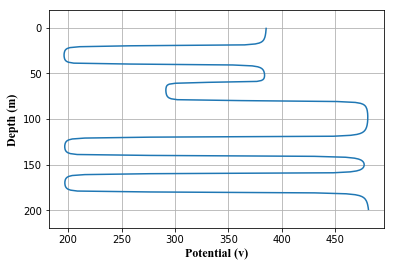

In [13]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 12,}
offset = 20
plt.figure()   # potential curve
plt.plot(V, pe.depth)  
plt.xlabel("Potential (v)", font1)
plt.ylabel("Depth (m)", font1) 
plt.ylim(np.max(pe.depth) + offset, np.min(pe.depth) - offset)
plt.grid()

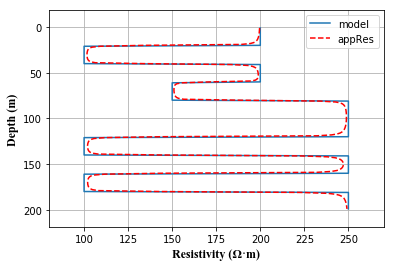

In [14]:
plt.figure()   # resistivity curve
plt.plot(trueRes, pe.depth)
plt.plot(appRes, pe.depth, 'r--') 
plt.xlabel("Resistivity (Ω·m)", font1)
plt.ylabel("Depth (m)", font1)
plt.xlim(np.min(trueRes) - offset, np.max(trueRes) + offset)
plt.ylim(np.max(pe.depth) + offset, np.min(pe.depth) - offset)
plt.legend(['model', 'appRes'])
plt.grid()